In [78]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import math

import itertools
import re

In [14]:
# Load pre-trained Pythia model and tokenizer
model_name = "EleutherAI/pythia-70m-deduped"  # Adjust as necessary
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Define a function to generate text until a period is encountered
def generate_until_period(input_text, temperature = 0.5, max_length=50):
    # Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)

    # Generate tokens until a period is encountered
    generated_ids = input_ids
    while True:
        # Get model logits for the input sequence
        logits = model(generated_ids).logits[:, -1, :] / temperature
        
        # Apply softmax to get probabilities for the next token
        probs = F.softmax(logits, dim=-1)
        
        # Sample a token from the probability distribution
        next_token_id = torch.multinomial(probs, num_samples=1).squeeze().item()
        
        # Append the generated token to the sequence
        generated_ids = torch.cat([generated_ids, torch.tensor([[next_token_id]], device=device)], dim=-1)
        
        # Decode the generated token
        next_token = tokenizer.decode(next_token_id)
        
        # Check if the token ends with sentence-ending punctuation
        if next_token[-1] in ['.', '!', '?']:
            break
        
        # Stop if the sequence length exceeds max_length
        if generated_ids.shape[1] > max_length:
            break
    
    # Decode the full generated sequence
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

input_text = "The number of bones in the human body is"
gen_sens = []

for i in range(100):
    generated_text = generate_until_period(input_text, temperature=0.25)
    print(generated_text)
    gen_sens.append(generated_text)

The number of bones in the human body is significant.
The number of bones in the human body is the number of the bones in the body.
The number of bones in the human body is the number of bones in the human body.
The number of bones in the human body is about 1.
The number of bones in the human body is the number of bones in the body.
The number of bones in the human body is the number of the bones in the body.
The number of bones in the human body is the number of bones in the body.
The number of bones in the human body is estimated to be 1.
The number of bones in the human body is not the number of bones in the body.
The number of bones in the human body is the number of the bones in the body.
The number of bones in the human body is estimated to be around 1.
The number of bones in the human body is the number of bones in the body.
The number of bones in the human body is the number of the bones in the body.
The number of bones in the human body is a measure of the number of bones in 

In [108]:
# Load pre-trained Pythia model and tokenizer
model_name = "EleutherAI/pythia-410m-deduped"  # Adjust as necessary
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def generate_until_period2(input_text, n, max_length=50):
    # Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)

    # Generate tokens until a period is encountered
    generated_ids = input_ids
    prob = []
    while True:
        # Get model logits for the input sequence
        logits = model(generated_ids).logits[:, -1, :]
        
        # Apply softmax to get probabilities for the next token
        probs = F.softmax(logits, dim=-1)

        # Get the indices of the two highest logits
        top2_indices = torch.topk(logits, n, dim=-1).indices.squeeze(dim=0)
        
        # Extract the probabilities for the top 2 tokens
        top2_probs = probs[0, top2_indices]
        
        # Normalize the probabilities (they should sum to 1)
        top2_probs = top2_probs / top2_probs.sum()

        # Sample a token from the top 2 probabilities
        next_token_id = torch.multinomial(top2_probs, num_samples=1).item()
        prob.append(top2_probs[next_token_id].item())
        
        # Append the generated token to the sequence
        generated_ids = torch.cat([generated_ids, torch.tensor([[top2_indices[next_token_id]]], device=device)], dim=-1)
        
        # Decode the generated token
        next_token = tokenizer.decode(top2_indices[next_token_id].item())
        
        # Check if the token ends with sentence-ending punctuation
        if next_token[-1] in ['.', '!', '?']:
            break
        
        # Stop if the sequence length exceeds max_length
        if generated_ids.shape[1] > max_length:
            break
    
    # Decode the full generated sequence
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text, prob

In [70]:
input_text = "The brain is"
num_traj = 10000
n=5

gen_sens = []

p_vals = []

for i in range(num_traj):
    generated_text, p = generate_until_period2(input_text, n)
    print(generated_text)
    val = np.prod(p)
    p_vals.append(val)
    gen_sens.append(generated_text)

The brain is a complex and it has been the main source of information for the brain, and is not the only one.
The brain, which contains the most important information, the body's brain is not able to predict the future.
The brain, which is the brain, is also the brain's own.
The brain.
The brain is not the same as the brain.
The brain.
The brain is also able to detect the presence or absence of other stimuli in the brain.
The brain, which is a complex system, is a computer, a computer, or any other device, or the user's brain, the device.
The brain is not able to distinguish whether there is a difference between the two and the two.
The brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem of the brainstem
The brain is the most important component in this area, and it is the most important component in our brain.
The brain is the same as a whole

In [85]:
def extract_unique_words(sentences):
    words = set()
    for sentence in sentences:
        # Remove periods and split into words, using a regular expression
        sentence_words = re.findall(r'\b\w+\b', sentence.lower())
        words.update(sentence_words)
    return words

# Extract unique words
unique_words = extract_unique_words(gen_sens)
print(len(unique_words))

2311


In [99]:
from collections import Counter
import re


# Step 1: Flatten the list of sentences into a list of words (lowercased and no punctuation)
all_words = []
for sentence in gen_sens:
    # Extract words, ignore punctuation, and convert to lowercase
    words = re.findall(r'\b\w+\b', sentence.lower())
    all_words.extend(words)

# Step 2: Count occurrences of each word
word_counts = Counter(all_words)

# Step 3: Extract words that appear more than 100 times
words_more_than_100 = [word for word, count in word_counts.items() if count > 100]

# Output the words that appear more than 100 times
print(words_more_than_100)


['the', 'brain', 'is', 'a', 'complex', 'and', 'it', 'has', 'been', 'source', 'of', 'information', 'for', 'not', 'only', 'one', 'which', 'most', 'important', 'body', 's', 'able', 'to', 'also', 'own', 'same', 'as', 'detect', 'or', 'other', 'in', 'system', 'computer', 'any', 'two', 'brainstem', 'component', 'this', 'our', 'man', 'who', 'had', 'woman', 'with', 'ability', 'expression', 'thing', 'can', 'do', 'human', 'was', 'very', 'an', 'animal', 'part', 'mind', 'large', 'structure', 'network', 'species', 'small', 'size', 'stem', 'heart', 'that', 'see', 'but', 'activity', 'derived', 'be', 'used', 'way', 'how', 'are', 'involved', 'nervous', 'have', 'capable', 'by', 'number', 'neurons', 'what', 'energy', 'its', 'kind', 'neural', 'all', 'great', 'many', 'single', 'individual', 'spinal', 'cord', 'powerful', 'tool', 'new', 'people', 'well', 'good', 'place', 'study', 'functions', 'brains', 'sized', 'different', 'child', 'young', 'medium', 'person', 'control', 'mental', 'state', 'you', 'first', 'a

In [120]:
def entropy(p, base=2):
    """Compute Shannon entropy of distribution p (list of floats summing to 1)."""
    log_fn = math.log if base == math.e else (lambda x: math.log(x, base))
    H = 0.0
    for pi in p:
        if pi > 0:
            H -= pi * log_fn(pi)
    return H

def mutual_information(samples, keyword1, keyword2):

    num_traj = len(samples)

    count1 = 0
    count2 = 0

    count_joint1 = 0
    count_joint2 = 0
    count_joint3 = 0
    count_joint4 = 0


    for sen in samples:
        if keyword1 in sen:
            count1 += 1
        
        if keyword2 in sen:
            count2 += 1

        if keyword1 in sen and keyword2 in sen:
            count_joint1 += 1
        
        if keyword1 not in sen and keyword2 not in sen:
            count_joint2 += 1

        if keyword1 in sen and keyword2 not in sen:
            count_joint3 += 1
        
        if keyword1 not in sen and keyword2 in sen:
            count_joint4 += 1


    prob1 = count1 / num_traj
    prob2 = count2 / num_traj
    prob1and2 = count_joint1 / num_traj
    prob1not2 = count_joint3 / num_traj
    prob2not1 = count_joint4 / num_traj
    probno1no2 = count_joint2 / num_traj

    joint_prob = [prob1and2, prob1not2, prob2not1, probno1no2]
    total_sum = sum(joint_prob)

    # Normalize the list by dividing each element by the total sum
    normalized_joint_prob = [prob / total_sum for prob in joint_prob]

    proba = [prob1, 1-prob1]
    total_sum = sum(proba)
    normalized_proba = [prob / total_sum for prob in proba]

    probb = [prob2, 1-prob2]
    total_sum = sum(probb)
    normalized_probb = [prob / total_sum for prob in probb]


    joint_entropy = entropy(normalized_joint_prob)
    h_a = entropy(normalized_proba)
    h_b = entropy(normalized_probb)

    mi = h_a + h_b - joint_entropy

    return mi, h_a, h_b, joint_entropy



In [101]:
print(unique_words)



{'steady', 'offense', 'c', 'artificial', 'basic', 'b1', 'institution', 'grievance', 'success', 'therapeutic', 'daily', 'gelf', 'fact', 'dimensions', 'stages', 'models', 'happiness', 'volume', 'opportunity', 'laugh', 'motif', 'phase', 'f', 'father', 'choices', 'cerebl', 'difficult', 'general', 'interact', 'cultured', 'destination', 'database', 'bodies', 'profound', 'patient', 'come', 'describe', 'convicted', 'techniques', 'behind', 'passive', 'power', 'filled', 'capability', 'jersey', 'period', 'link', 'source', 'organ', 'message', 'neurogenesis', 'wellness', 'dementia', 'step', 'production', 'measurement', 'oligopoly', 'habitats', 'unconscious', 'serotoninergic', 'dark', 'measure', 'ever', 'active', 'memories', 'he', 'him', 'tube', 'parotaxic', 'intelligent', 'twentieth', 'flexible', 'concern', 'were', 'about', 'hospital', 'serotonin', 'writing', 'spinalstemstemstemstemstemstemstemstemstemstemstemstemstemstemstemstemstemstemstemstem', 'networked', 'shape', 'cardiovascular', 'plastic', 

In [102]:
miis = []
mii_vals = []
unique_words = extract_unique_words(words_more_than_100)

unique_words.remove('the')
unique_words.remove('brain')

for w1, w2 in itertools.combinations(unique_words, 2):

    mi, h_a, h_b, h_joint = mutual_information(gen_sens, w1, w2)
    miis.append(((w1,w2),mi))
    mii_vals.append(mi)
sorted_miis = sorted(miis, key=lambda x: x[1], reverse=True)  # reverse=True for descending


In [132]:
print(sorted_miis)

[(('brains', 'brainstem'), 0.4903066054728652), (('an', 'and'), 0.412570415927465), (('stem', 'brainstem'), 0.40891402771320273), (('stem', 'brains'), 0.3541734091188752), (('s', 'is'), 0.3301177668169013), (('man', 'human'), 0.3297463242711185), (('has', 'as'), 0.1940782564609409), (('all', 'small'), 0.19218971417504643), (('or', 'for'), 0.18346255693182334), (('most', 'important'), 0.16331221768214), (('two', 'network'), 0.16248111328283643), (('important', 'or'), 0.15703780127230882), (('powerful', 'we'), 0.14326214283608962), (('to', 'able'), 0.13999382305013608), (('an', 'man'), 0.134262945086852), (('stem', 'system'), 0.13334204401132543), (('it', 'with'), 0.1256597284424359), (('information', 'for'), 0.12368992090713482), (('source', 'our'), 0.1194776685289557), (('spinal', 'cord'), 0.11381869677899373), (('be', 'been'), 0.11323935993012813), (('one', 'only'), 0.1047033592959915), (('cerebral', 'cortex'), 0.09330316198674418), (('has', 'been'), 0.09272343052917997), (('same', 'a

Text(0.5, 1.0, '70m Model: The brain is...')

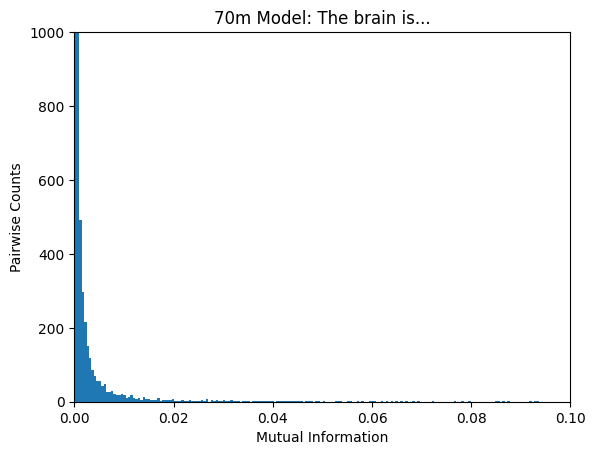

In [135]:
nz_vals = []

for val in mii_vals:
    if val < 1e-5:
        pass
    else:
        nz_vals.append(val)


plt.hist(nz_vals, bins=1000)
plt.xlim(0,0.1)
plt.xlabel('Mutual Information')
plt.ylabel('Pairwise Counts')
plt.ylim(0,1000)
plt.title('70m Model: The brain is...')

In [107]:
print(sorted_miis)

[(('brains', 'brainstem'), 0.4903066054728652), (('an', 'and'), 0.412570415927465), (('stem', 'brainstem'), 0.40891402771320273), (('stem', 'brains'), 0.3541734091188752), (('s', 'is'), 0.3301177668169013), (('man', 'human'), 0.3297463242711185), (('has', 'as'), 0.1940782564609409), (('all', 'small'), 0.19218971417504643), (('or', 'for'), 0.18346255693182334), (('most', 'important'), 0.16331221768214), (('two', 'network'), 0.16248111328283643), (('important', 'or'), 0.15703780127230882), (('powerful', 'we'), 0.14326214283608962), (('to', 'able'), 0.13999382305013608), (('an', 'man'), 0.134262945086852), (('stem', 'system'), 0.13334204401132543), (('it', 'with'), 0.1256597284424359), (('information', 'for'), 0.12368992090713482), (('source', 'our'), 0.1194776685289557), (('spinal', 'cord'), 0.11381869677899373), (('be', 'been'), 0.11323935993012813), (('one', 'only'), 0.1047033592959915), (('cerebral', 'cortex'), 0.09330316198674418), (('has', 'been'), 0.09272343052917997), (('same', 'a

In [109]:
input_text2 = "The brain is"
num_traj = 10000
n=5

gen_sens2 = []

p_vals2 = []

for i in range(num_traj):
    generated_text, p = generate_until_period2(input_text2, n)
    if i % 500 == 0:
        print(i)
    val = np.prod(p)
    p_vals2.append(val)
    gen_sens2.append(generated_text)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


KeyboardInterrupt: 

In [114]:
unique_words2 = extract_unique_words(gen_sens2)
print(len(unique_words2))

all_words2 = []
for sentence in gen_sens2:
    # Extract words, ignore punctuation, and convert to lowercase
    words = re.findall(r'\b\w+\b', sentence.lower())
    all_words2.extend(words)

word_counts2 = Counter(all_words2)
words_more_than_100_2 = [word for word, count in word_counts2.items() if count > 100]
print(words_more_than_100_2)

miis2 = []
mii_vals2 = []
unique_words2 = extract_unique_words(words_more_than_100_2)

unique_words2.remove('the')
unique_words2.remove('brain')

print(unique_words2)

2179
['the', 'brain', 'is', 'a', 'complex', 'interconnected', 'system', 'an', 'organ', 'that', 'constantly', 'changing', 'highly', 'organized', 'sophisticated', 'and', 'it', 'very', 'to', 'most', 'in', 'our', 'has', 'been', 'for', 'environment', 'as', 'complicated', 'many', 'functions', 'we', 't', 'understand', 'center', 'of', 'evolved', 'designed', 'process', 'world', 'ability', 'learn', 'information', 'from', 'which', 'not', 'all', 'with', 'processes', 'body', 'mind', 'amazing', 'machine', 'learning', 'its', 'dynamic', 'extremely', 'can', 'be', 'into', 'parts', 'important', 's', 'are', 'different', 'think', 'place', 'so', 'thing', 'way', 'like', 'do', 'make', 'you', 'simple', 'made', 'on', 'single', 'but', 'composed', 'number', 'each', 'other', 'responsible', 'neurons', 'communicate', 'one', 'cells', 'sensory', 'largest', 'being', 'only', 'also', 'work', 'network', 'emotions', 'how', 'have', 'computer', 'just', 'human', 'function', 'by', 'memory', 'lot', 'connected', 'processing', 's

In [123]:
miis2 = []
mii_vals2 = []

unique_words2 = extract_unique_words(words_more_than_100_2)
unique_words2.remove('the')
unique_words2.remove('brain')

for w1, w2 in itertools.combinations(unique_words2, 2):

    mi, h_a, h_b, h_joint = mutual_information(gen_sens2, w1, w2)
    miis2.append(((w1,w2),mi))
    mii_vals2.append(mi)
sorted_miis2 = sorted(miis2, key=lambda x: x[1], reverse=True)  # reverse=True for descending

nz_vals2 = []

for val in mii_vals2:
    if val < 1e-5:
        pass
    else:
        nz_vals2.append(val)

In [127]:
print(sorted_miis2)

[(('connected', 'interconnected'), 0.3018467147223851), (('function', 'functions'), 0.28811141579505617), (('has', 'as'), 0.2384417375013289), (('an', 'and'), 0.23271617521822718), (('network', 'work'), 0.22958533963728545), (('part', 'parts'), 0.22478071044836268), (('information', 'for'), 0.21125236127137192), (('an', 'organ'), 0.20889453890083987), (('it', 'with'), 0.18116972796498643), (('process', 'information'), 0.1626045817094075), (('also', 'so'), 0.15553960713256987), (('learning', 'learn'), 0.13669120726226064), (('process', 'processes'), 0.1334465382184598), (('most', 'body'), 0.13029541323567206), (('organ', 'machine'), 0.11898360708202449), (('function', 'on'), 0.1182483720463734), (('process', 'for'), 0.10431386889525274), (('on', 'neurons'), 0.10110509599659889), (('not', 'only'), 0.0933306227278976), (('so', 'sophisticated'), 0.09316873014462601), (('responsible', 'for'), 0.09237067641203645), (('on', 'of'), 0.09010725988401247), (('of', 'neurons'), 0.08754794766129592)

(0.0, 1000.0)

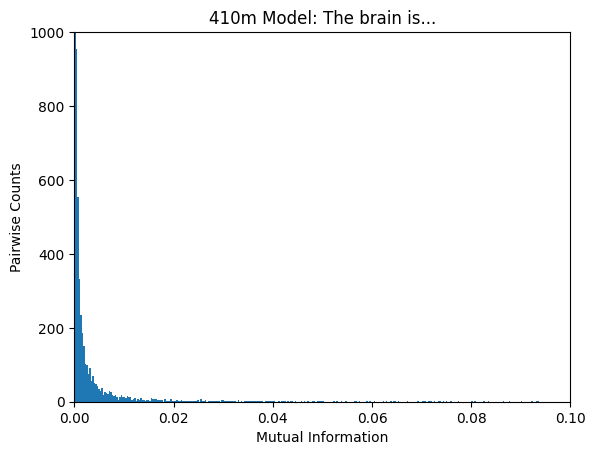

In [134]:
plt.hist(nz_vals2, bins=1000)
plt.xlim(0,0.1)
plt.xlabel('Mutual Information')
plt.ylabel('Pairwise Counts')
plt.title('410m Model: The brain is...')
plt.ylim(0,1000)
